In [80]:
import sys
sys.path.append('..')

# import numpy as np
import autograd.numpy as np
import scipy as sp
import pandas as pd
from autograd import hessian, grad
import matplotlib.pyplot as plt

from noaa.daily import stations_info, hist_daily
rng = np.random.default_rng()

In [22]:
n_sample = 10000
x_data = rng.normal(0.0,scale=1.0,size=n_sample)

In [23]:
u = 2.0
x_exceed = x_data[np.where(x_data>u)]-u

In [24]:
xi, _, sigma = sp.stats.genpareto.fit(x_exceed,floc=0.0)
(xi,sigma)

(-0.10735436076223318, 0.42958545819425065)

In [6]:
PRCP_NY = hist_daily(('USC00304912', 'USW00094728'),'PRCP')
s = PRCP_NY['USW00094728'].copy()

In [7]:
u = 50.0
s2_exc = s[(s>u)]-u

In [8]:
def gdp_logp(x,xi,sigma,mu=0.0):
    z = (x-mu)/sigma
    return -np.log(sigma) - (1.0+1.0/xi)*np.log(1.0+xi*z)

In [9]:
def neg_ll(theta : tuple):
    xi, sigma = theta
    x_exceed = s2_exc.values

    return -1.0 * np.sum(gdp_logp(x_exceed,xi,sigma))


In [10]:
def gdp_returnlevel(returnperiod, mu, xi, sigma, p_mu, period = 1.0):
    m = returnperiod * period
    return mu + (sigma/xi) * (np.power(m * p_mu,xi)-1.0)

In [11]:
xi, sigma = sp.optimize.fmin(neg_ll,(0.001,1.0))
(xi, sigma)

Optimization terminated successfully.
         Current function value: 1432.496918
         Iterations: 72
         Function evaluations: 135


(0.11864894493352365, 18.064446381172175)

In [145]:
class GPDMLE:

    def __init__(self, u):
        self.u = u
        
        self.xi = None
        self.sigma = None

        self.x_exceed = None
        self.n_sample = None
        self.n_exceed = None

    
    def neg_ll(self, theta) -> float:
        xi, sigma = theta
        return -1.0 * np.sum(gdp_logp(self.x_exceed,xi,sigma))

    def fit(self, x_data):

        self.x_exceed = x_data[np.where(x_data>self.u)]-self.u  

        self.n_sample = len(x_data)
        self.n_exceed = len(x_exceed)

        self.xi, self.sigma = sp.optimize.fmin(self.neg_ll,(0.001,1.0))

    def p_u(self) -> float:
        return self.n_exceed/self.n_sample

    def p_u_var(self) -> float:
        p = self.p_u()
        return p*(1-p)/self.n_sample


    def cov(self) -> np.ndarray:
        fisher_info =  hessian(self.neg_ll)(np.array([self.xi,self.sigma]))
        cov = np.linalg.inv(fisher_info)
        return cov

    def get_params(self, include_ci=False) -> dict:

        params = {
            'xi'    : self.xi,
            'sigma' : self.sigma
        }

        if include_ci:
            xi_se, sigma_se = np.sqrt(np.diag(self.cov()))

            ci = {
                'xi'    : (self.xi-2*xi_se,self.xi+2*xi_se),
                'sigma' : (self.sigma-2*sigma_se,self.sigma+2*sigma_se)
            }

            return (params, ci)
        else:
            return params

    def return_level(self, return_period, period = 1.0):

        return gdp_returnlevel(return_period, self.u, self.xi, self.sigma, self.p_u(), period = period)

    def _return_level_se(self, return_period, period = 1.0):

        def rl(theta):
            xi, sigma, p_u = theta
            return  gdp_returnlevel(return_period, self.u, xi, sigma, p_u, period = period)

        delta = grad(rl)(np.array([self.xi, self.sigma, self.p_u()]))

        cov = np.zeros((3,3))
        cov[:2,:2] = self.cov()
        cov[2,2] = self.p_u_var()

        return np.sqrt((delta.dot(cov)).dot(delta))

    def return_level_se(self, return_period, period = 1.0):

        return np.vectorize(self._return_level_se)(return_period, period = period)

    
    def _return_periods(self, n=20):

        return 1.0/np.linspace(self.n_exceed/self.n_sample, 1.0/self.n_sample, n)


    def return_level_plot(self, include_ci = False, log_scale=True):

        rp = self._return_periods(n = 50)
        rl = self.return_level(rp)

        plt.plot(rp,rl)
        
        if include_ci:
            rl_se = self.return_level_se(rp)
            plt.fill_between(rp, rl-2.0*rl_se,rl+2.0*rl_se,alpha=0.25)
        
        plt.xlabel('return period')
        plt.ylabel('return level')

        if log_scale:
            plt.xscale('log')
        plt.show()



In [146]:
gpddemo = GPDMLE(2.0)
gpddemo.fit(x_data)

Optimization terminated successfully.
         Current function value: 10.351038
         Iterations: 59
         Function evaluations: 110


In [147]:
gpddemo.get_params(include_ci=True)

({'xi': -0.10735350226496125, 'sigma': 0.4295826116817366},
 {'xi': (-0.22838787954672976, 0.013680875016807259),
  'sigma': (0.3516956339051176, 0.5074695894583556)})

In [148]:
gpddemo.return_level(100.0)

2.319345336169489

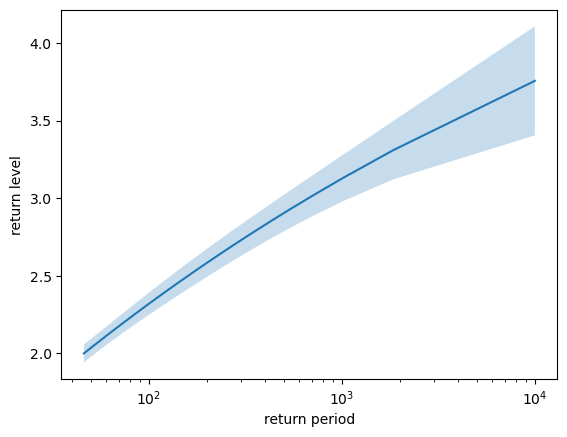

In [151]:
gpddemo.return_level_plot(include_ci=True)